# Derivative-free Optimisation of Neural Networks in Reinforcement Learning for Process Control: CSTR Case Study

```{attention} 
The code is based on a tutorial that can be found here: https://edgarsmdn.github.io/MLCE_book/07_RL_Control.html
```



This is the code used for developing and testing the algorithms for the report.

Import necessary modules for the code:

In [1]:
import torch
import torch.nn.functional as Ffunctional
import copy
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.ticker import StrMethodFormatter
from pylab import grid
import time
import random

The model of CSTR is presented in the following block:

In [2]:
#@title CSTR code from tutorial 6

eps  = np.finfo(float).eps # computer computational precision

###############
#  CSTR model #
###############

# Taken from http://apmonitor.com/do/index.php/Main/NonlinearControl

def cstr(x,t,u):

    # ==  Inputs == #
    Tc  = u   # Temperature of cooling jacket (K)

    # == States == #
    Ca = x[0] # Concentration of A in CSTR (mol/m^3)
    T  = x[1] # Temperature in CSTR (K)

    # == Process parameters == #
    Tf     = 350    # Feed temperature (K)
    q      = 100    # Volumetric Flowrate (m^3/sec)
    Caf    = 1      # Feed Concentration (mol/m^3)
    V      = 100    # Volume of CSTR (m^3)
    rho    = 1000   # Density of A-B Mixture (kg/m^3)
    Cp     = 0.239  # Heat capacity of A-B Mixture (J/kg-K)
    mdelH  = 5e4    # Heat of reaction for A->B (J/mol)
    EoverR = 8750   # E -Activation energy (J/mol), R -Constant = 8.31451 J/mol-K
    k0     = 7.2e10 # Pre-exponential factor (1/sec)
    UA     = 5e4    # U -Heat Transfer Coefficient (W/m^2-K) A -Area - (m^2)
    
    # == Equations == #
    rA     = k0*np.exp(-EoverR/T)*Ca # reaction rate
    dCadt  = q/V*(Caf - Ca) - rA     # Calculate concentration derivative
    dTdt   = q/V*(Tf - T) \
              + mdelH/(rho*Cp)*rA \
              + UA/V/rho/Cp*(Tc-T)   # Calculate temperature derivative

    # == Return xdot == #
    xdot    = np.zeros(2)
    xdot[0] = dCadt
    xdot[1] = dTdt
    return xdot

data_res = {} 
# Initial conditions for the states
x0             = np.zeros(2)
x0[0]          = 0.87725294608097
x0[1]          = 324.475443431599
data_res['x0'] = x0

# Time interval (min)
n             = 101 # number of intervals
tp            = 25 # process time (min)
t             = np.linspace(0,tp,n)
data_res['t'] = t
data_res['n'] = n

# Store results for plotting
Ca = np.zeros(len(t));      Ca[0]  = x0[0]
T  = np.zeros(len(t));      T[0]   = x0[1]    
Tc = np.zeros(len(t)-1);   

data_res['Ca_dat'] = copy.deepcopy(Ca)
data_res['T_dat']  = copy.deepcopy(T) 
data_res['Tc_dat'] = copy.deepcopy(Tc)

# noise level
noise             = 0.1
data_res['noise'] = noise

# control upper and lower bounds
data_res['Tc_ub']  = 305
data_res['Tc_lb']  = 295
Tc_ub              = data_res['Tc_ub']
Tc_lb              = data_res['Tc_lb']

# desired setpoints
n_1                = int(n/3)
n_2                = int(n/3)
n_3                = n - n_1 - n_2
Ca_des             = [0.85 for i in range(n_1)] + [0.9 for i in range(n_2)] + [0.8 for i in range(n_3)] # Desired C_A set point (mol/m^3)
T_des              = [325 for i in range(n_1)] + [320 for i in range(n_2)] + [330 for i in range(n_3)] # Desired T set point (K)
data_res['Ca_des'] = Ca_des
data_res['T_des']  = T_des

##################
# PID controller #
##################

def PID(Ks, x, x_setpoint, e_history):

    Ks    = np.array(Ks)
    Ks    = Ks.reshape(7, order='C')

    # K gains
    KpCa = Ks[0]; KiCa = Ks[1]; KdCa = Ks[2]
    KpT  = Ks[3]; KiT  = Ks[4]; KdT  = Ks[5]; 
    Kb   = Ks[6]
    # setpoint error
    e = x_setpoint - x
    # control action
    u  = KpCa*e[0] + KiCa*sum(e_history[:,0]) + KdCa*(e[0]-e_history[-1,0])
    u += KpT *e[1] + KiT *sum(e_history[:,1]) + KdT *(e[1]-e_history[-1,1])
    u += Kb
    u  = min(max(u,data_res['Tc_lb']),data_res['Tc_ub'])

    return u

Code for creating the plots to visualise the results:

In [13]:
#@title Ploting routines

####################################
# plot control actions performance #
####################################

def plot_simulation(Ca_dat, T_dat, Tc_dat, Ca_dat2, T_dat2, Tc_dat2, data_simulation):    # Plotting two simulation results
    
    Ca_des = data_simulation['Ca_des']
    T_des = data_simulation['T_des']
    font_size = 8

    label1 = 'PID with PSO' # Labelling for the plots
    label2 = 'Firefly Algorithm'

    # cols = ['#e31a1c', '#33a02c', '#ff6347', '#008080', '#ff7f00', '#1f78b4']
    cols = ['#ff6347', '#008080', '#ff6347', '#008080', '#ff6347', '#008080',] # Colours for the plots
    
    plt.figure(figsize=(8, 6))

    plt.subplot(3,1,1)
    plt.plot(t, np.median(Ca_dat,axis=1), '-', color=cols[0], lw=3, label='Algorithm 1')
    plt.plot(t, np.median(Ca_dat2,axis=1), '-', color=cols[1], lw=3, label='Algorithm 2')
    plt.gca().fill_between(t, np.min(Ca_dat,axis=1), np.max(Ca_dat,axis=1), 
                           color=cols[0], alpha=0.2)
    plt.gca().fill_between(t, np.min(Ca_dat2,axis=1), np.max(Ca_dat2,axis=1),
                            color=cols[1], alpha=0.2)
    plt.step(t, Ca_des, '--', lw=1.5, color='black')
    plt.ylabel('$C_a$ $(mol/m^3)$')
    plt.xlabel('Time $(min)$')
    legend_title = 'Concentration of A in CSTR'
    legend_labels = [label1, label2]
    legend_lines = [Line2D([0], [0], color=cols[0]), Line2D([0], [0], color=cols[1])]
    plt.legend(handles=legend_lines, labels=legend_labels, title=legend_title, title_fontsize= font_size, fontsize=font_size,loc='best') 
    plt.xlim(min(t), max(t))

    plt.subplot(3,1,2)
    plt.plot(t, np.median(T_dat,axis=1), '-', color=cols[2], lw=3, label='Algorithm 1')
    plt.plot(t, np.median(T_dat2,axis=1), '-', color=cols[3], lw=3, label='Algorithm 2')
    plt.gca().fill_between(t, np.min(T_dat,axis=1), np.max(T_dat,axis=1), 
                           color=cols[2], alpha=0.2)
    plt.gca().fill_between(t, np.min(T_dat2,axis=1), np.max(T_dat2,axis=1),
                            color=cols[3], alpha=0.2)
    plt.step(t, T_des, '--', lw=1.5, color='black')
    plt.ylabel('$T$ $(K)$')
    plt.xlabel('Time $(min)$')
    legend_title = 'Reactor Temperature'
    legend_labels = [label1, label2]
    legend_lines = [Line2D([0], [0], color=cols[2]), Line2D([0], [0], color=cols[3])]
    plt.legend(handles=legend_lines, labels=legend_labels, title=legend_title, title_fontsize= font_size, fontsize=font_size,loc='best')
    plt.xlim(min(t), max(t))

    plt.subplot(3,1,3)
    plt.step(t[1:], np.median(Tc_dat,axis=1), '--', color=cols[4], lw=3, label='Algorithm 1')
    plt.step(t[1:], np.median(Tc_dat2,axis=1), '--', color=cols[5], lw=3, label='Algorithm 2')
    plt.ylabel('Cooling $T$ $(K)$')
    plt.xlabel('Time $(min)$')
    legend_title = 'Jacket Temperature'
    legend_labels = [label1, label2]
    legend_lines = [Line2D([0], [0], color=cols[4]), Line2D([0], [0], color=cols[5])]
    plt.legend(handles=legend_lines, labels=legend_labels, title=legend_title, title_fontsize= font_size, fontsize=font_size,loc='best')
    plt.xlim(min(t), max(t))

    plt.tight_layout()
    plt.show()

##################
# Training plots #
##################

def plot_training(data_simulation, repetitions):
    t        = data_simulation['t'] 
    Ca_train = np.array(data_simulation['Ca_train'])
    T_train = np.array(data_simulation['T_train'])
    Tc_train = np.array(data_simulation['Tc_train'])
    Ca_des   = data_simulation['Ca_des']
    T_des    = data_simulation['T_des']

    c_    = [(repetitions - float(i))/repetitions for i in range(repetitions)]

    plt.figure(figsize=(8, 5))

    plt.subplot(3,1,1)
    for run_i in range(repetitions):
        plt.plot(t, Ca_train[run_i,:], 'r-', lw=1, alpha=c_[run_i])
    plt.step(t, Ca_des, '--', lw=1.5, color='black')
    plt.ylabel('$C_a$ $(mol/m^3)$')
    plt.xlabel('Time $(min)$')
    plt.legend(['Concentration of A in CSTR'],loc='best')
    plt.title('Training plots')
    plt.ylim([.75, .95])
    plt.xlim(min(t), max(t))
    grid(True)

    plt.subplot(3,1,2)
    for run_i in range(repetitions):
        plt.plot(t, T_train[run_i,:], 'c-', lw=1, alpha=c_[run_i])
    plt.step(t, T_des, '--', lw=1.5, color='black')
    plt.ylabel('$T$ $(K)$')
    plt.xlabel('Time $(min)$')
    plt.legend(['Reactor Temperature'],loc='best')
    plt.ylim([335, 317])
    plt.xlim(min(t), max(t))
    grid(True)

    plt.subplot(3,1,3)
    for run_i in range(repetitions):
        plt.step(t[1:], Tc_train[run_i,:], 'b--', lw=1, alpha=c_[run_i])
    plt.ylabel('Cooling $T$ $(K)$')
    plt.xlabel('Time $(min)$')
    plt.legend(['Jacket Temperature'],loc='best')
    plt.xlim(min(t), max(t))
    grid(True)
    
    plt.tight_layout()

    plt.show()

#####################
# Convergence plots #
#####################

def plot_convergence(Xdata, best_Y, Objfunc=None):
    '''
    Plots to evaluate the convergence of standard Bayesian optimization algorithms
    '''
    ## if f values are not given
    f_best  = 1e8
    if best_Y==None: 
        best_Y = []
        for i_point in range(Xdata.shape[0]):
            f_point = Objfunc(Xdata[i_point,:], collect_training_data=False)
            if f_point < f_best:
                f_best = f_point 
            best_Y.append(f_best)
        best_Y = np.array(best_Y)

    n = Xdata.shape[0]
    aux = (Xdata[1:n,:]-Xdata[0:n-1,:])**2
    distances = np.sqrt(aux.sum(axis=1))

    ## Distances between consecutive x's
    plt.figure(figsize=(9,3))
    plt.subplot(1, 2, 1)
    plt.plot(list(range(n-1)), distances, '-ro')
    plt.xlabel('Iteration')
    plt.ylabel('d(x[n], x[n-1])')
    plt.title('Distance between consecutive x\'s')
    plt.xlim(0, n)
    grid(True)

    # Best objective value found over iterations
    plt.subplot(1, 2, 2)
    plt.plot(list(range(n)), best_Y,'-o')
    plt.title('Value of the best selected sample')
    plt.xlabel('Iteration')
    plt.ylabel('Best y')
    grid(True)
    plt.xlim(0, n)
    plt.tight_layout()
    plt.show()

#####################
# Algorithm performance plots #
#####################

def performance_plots(iterations, time, gbest, multiruns=False):
    
    iterations = list(range(1, len(gbest)+1))  
    
    plt.figure(figsize=(8, 8))

    plt.subplot(2,1,1)
    plt.plot(iterations, gbest, 'r-')
    if multiruns == True:
        plt.plot(iterations, np.median(gbest,axis=1), 'r-')
        plt.gca().fill_between(iterations, np.min(gbest,axis=1), np.max(gbest,axis=1), 
                               color='r', alpha=0.2)
    plt.ylabel('Best reward')
    plt.xlabel('Iterations')
    plt.title('Best Reward vs Iterations')
    plt.xlim(min(iterations), max(iterations))
    plt.yscale('log')



    plt.subplot(2,1,2)
    plt.plot(time, gbest, 'b-')
    if multiruns == True:
        plt.plot(time, np.median(gbest,axis=1), 'b-')
        plt.gca().fill_between(time, np.min(gbest,axis=1), np.max(gbest,axis=1), 
                               color='b', alpha=0.2)
    plt.ylabel('Best reward')
    plt.xlabel('Time (s)')
    plt.title('Best Reward vs Time')
    plt.xlim(min(time), max(time))
    plt.yscale('log')


    plt.tight_layout()

    plt.show()




    

Neural network policy initialisation:

In [5]:
##################
# Policy Network #
##################

class Net(torch.nn.Module):
  # in current form this is a linear function (wouldn't expect great performance here)
    def __init__(self, **kwargs):
        super(Net, self).__init__()

        self.dtype    = torch.float

        # Unpack the dictionary 
        self.args     = kwargs

        # Get info of machine
        self.use_cuda = torch.cuda.is_available() 
        self.device   = torch.device("cpu")

        # Define ANN topology 
        self.input_size = self.args['input_size']
        self.output_sz  = self.args['output_size']
        self.hs1        = self.input_size*2 
        self.hs2        = self.output_sz*2 

        # Define layers 
        self.hidden1 = torch.nn.Linear(self.input_size, self.hs1)
        self.hidden2 = torch.nn.Linear(self.hs1, self.hs2)
        self.output  = torch.nn.Linear(self.hs2, self.output_sz)

    def forward(self, x):
        #x = torch.tensor(x.view(1,1,-1)).float() # re-shape tensor
        x = x.view(1, 1, -1).float()
        y = Ffunctional.leaky_relu(self.hidden1(x), 0.1)
        y = Ffunctional.leaky_relu(self.hidden2(y), 0.1)
        y = Ffunctional.relu6(self.output(y))   # range (0,6)

        return y

Normalisation of inputs (states and set point errors) and actions:

In [6]:
# normalization for states and actions 
data_res['x_norm'] = np.array([[.8, 315,0, 0],[.1, 10,.1, 20]]) # [mean],[range]
data_res['u_norm'] = np.array([[10/6],[295]])    # [range/6],[bias]

The objective function for the policy network:


In [7]:
def J_PolicyCSTR(policy, data_res=data_res, policy_alg='PID', 
                 collect_training_data=True, traj=False, episode=False):
    
    # load data
    Ca    = copy.deepcopy(data_res['Ca_dat'])
    T     = copy.deepcopy(data_res['T_dat'])
    Tc    = copy.deepcopy(data_res['Tc_dat'])
    t     = copy.deepcopy(data_res['t']) 
    x0    = copy.deepcopy(data_res['x0'])    
    noise = data_res['noise']
    
    # setpoints      
    Ca_des = data_res['Ca_des']; T_des = data_res['T_des']
    
    # upper and lower bounds
    Tc_ub  = data_res['Tc_ub'];  Tc_lb  = data_res['Tc_lb']
    
    # normalized states and actions
    x_norm = data_res['x_norm']; u_norm = data_res['u_norm'];

    # initiate
    x         = x0
    e_history = []

    # log probs
    if policy_alg == 'PG_RL':
      log_probs = [None for i in range(len(t)-1)]
    
    # Simulate CSTR
    for i in range(len(t)-1):
        # delta t
        ts      = [t[i],t[i+1]]
        # desired setpoint
        x_sp    = np.array([Ca_des[i],T_des[i]])

        #### PID ####
        if policy_alg == 'PID':
          if i == 0:
            Tc[i] = PID(policy, x, x_sp, np.array([[0,0]]))
          else:
            Tc[i] = PID(policy, x, x_sp, np.array(e_history))

        # --------------> New compared to tutorial 6 <-------------------
        #### Stochastic Policy Search ####
        elif policy_alg == 'SPS_RL':
          xk      = np.hstack((x,x_sp-x))
          # state preprocesing
          xknorm       = (xk-x_norm[0])/x_norm[1]
          xknorm_torch = torch.tensor(xknorm)
          # compute u_k from policy
          mean_uk      = policy(xknorm_torch).detach().numpy()
          u_k          = np.reshape(mean_uk, (1, 1))
          u_k          = u_k*u_norm[0] + u_norm[1]
          u_k          = u_k[0]
          u_k          = min(max(u_k, Tc_lb), Tc_ub)
          Tc[i]        = u_k[0]

        #### Policy Gradients #### 
        # See next section for the explanation on Policy gradients!
        elif policy_alg == 'PG_RL':
          xk      = np.hstack((x,x_sp-x))
          # state preprocesing
          xknorm       = (xk-x_norm[0])/x_norm[1]
          xknorm_torch = Tensor(xknorm)
          # compute u_k distribution
          m, s                      = policy(xknorm_torch)[0,0]
          s                         = s + eps
          mean_uk, std_uk           = mean_std(m, s)
          u_k, logprob_k, entropy_k = select_action(mean_uk, std_uk)
          u_k                       = np.reshape(u_k.numpy(), (nu))
          # hard bounds on inputs
          u_k                       = min(max(u_k, Tc_lb), Tc_ub)
          Tc[i]                     = u_k
          log_probs[i] = logprob_k
        # ----------------------------------------------------------------

        # simulate system
        y            = odeint(cstr,x,ts,args=(Tc[i],))
        # add process disturbance
        s            = np.random.uniform(low=-1, high=1, size=2)
        Ca[i+1]      = y[-1][0] + noise*s[0]*0.1    
        T[i+1]       = y[-1][1] + noise*s[1]*5     
        # state update
        x[0]         = Ca[i+1]
        x[1]         = T[i+1]
        # compute tracking error
        e_history.append((x_sp-x))

    # == objective == #
    # tracking error
    error = np.abs(np.array(e_history)[:,0])/0.2+np.abs(np.array(e_history)[:,1])/15
    # penalize magnitud of control action
    u_mag = np.abs(Tc[:]-Tc_lb)/10
    u_mag = u_mag/10
    # penalize change in control action
    u_cha = np.abs(Tc[1:]-Tc[0:-1])/10
    u_cha = u_cha/10

    # collect data for plots
    if collect_training_data:
        data_res['Ca_train'].append(Ca)
        data_res['T_train'].append(T)
        data_res['Tc_train'].append(Tc)
        data_res['err_train'].append(error)
        data_res['u_mag_train'].append(u_mag)
        data_res['u_cha_train'].append(u_cha)

    # sums
    error = np.sum(error)
    u_mag = np.sum(u_mag)
    u_cha = np.sum(u_cha)

    if episode:
      # See next section for the explanation on Policy gradients!
      sum_logprob = sum(log_probs)
      reward      = -(error + u_mag + u_cha)
      return reward, sum_logprob
    
    if traj:
      return Ca, T, Tc
    else:
      return error + u_mag + u_cha


Defining policy optimisation functions:

In [8]:
#######################
# auxiliary functions #
#######################

# Auxillary function for uniform sampling
def sample_uniform_params(params_prev, param_max, param_min):
    params = {k: torch.rand(v.shape)* (param_max - param_min) + param_min \
              for k, v in params_prev.items()}              
    return params

# Auxillary function for local sampling
def sample_local_params(params_prev, param_max, param_min):
    params = {k: torch.rand(v.shape)* (param_max - param_min) + param_min + v \
              for k, v in params_prev.items()}              
    return params

# Aux function for converting list of tensors to a single tensor, layer sizes and shapes
def extract_NN_values(list_of_params):
    rows_tensors = []
    for params_dict in list_of_params:
        layer_shapes = []
        list_tensors = []
        layer_sizes = []
        for tensor in params_dict.values():
            list_tensors.append(torch.flatten(tensor))
            layer_sizes.append(torch.numel(tensor))
            layer_shapes.append(tensor.size())
        row_tensors = torch.cat(list_tensors)
        rows_tensors.append(row_tensors)
    mat_tensors = torch.stack(rows_tensors)
    return mat_tensors, layer_sizes, layer_shapes

# Aux function for converting a tensor to a dictionary of tensors    
def convert_to_NN_dict(tensor, layer_sizes, layer_shapes, params):
    split_indices = [sum(layer_sizes[0:i+1]) for i in range(len(layer_sizes))]
    NN_values = torch.tensor_split(tensor.squeeze(), split_indices, dim=0)
    NN_values_reshaped = [torch.reshape(NN_values[i], layer_shapes[i]) for i in range(len(layer_shapes))]
    dict_names = list(params.keys())
    dict_params = {dict_names[i]: NN_values_reshaped[i] for i in range(len(dict_names))}
    return dict_params
    


###################
# Genetic Algorithm
###################
    
def GeneticSearch(lower_bound=-5, upper_bound=5, mutation_rate=0.1, iterations=12, sample_size=10):
    
    # initialise time and reward history
    start = time.time()
    gbest_history = []
    time_axis = []

    # problem initialisaion
    nu = 1
    nx = 2
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5
    
    # initialise population
    population = []
    
    
    # initialise inputs
    for i in range(sample_size):
        member = sample_uniform_params(params, lower_bound, upper_bound)
        population.append(copy.deepcopy(member))
        
    #print("Population before:", population)
        
    for i in range(iterations+1):
        pop_tensor, layer_sizes, layer_shapes = extract_NN_values(population)
        fun_population = []
        print("Iteration", i)
        for j in range(len(population)):
            current_params = population[j] # fetch current NN parameter set
            policy_net.load_state_dict(current_params) # load set into NN
            reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL') # evaluate NN in the controller simulation
            fun_population.append(reward) # add reward to the corresponding list
        fitness_scores = [1/value for value in fun_population] # evaluate the fitness score for each set of params
        total_fitness = sum(fitness_scores) # calculate total fitness score
        best_index = fitness_scores.index(max(fitness_scores))
        best_guess = pop_tensor[best_index, :]
        new_generation = [best_guess] # it automatically becomes part of the new generation
        while len(new_generation) < sample_size:
            selection_probs = [score / total_fitness for score in fitness_scores] # define selection probabilities
            (index1, index2) = random.choices(list(range(len(selection_probs))), selection_probs, k=2) # select two parents
            parent1 = pop_tensor[index1, :]
            parent2 = pop_tensor[index2, :]
            children = []
            index = random.randint(1, parent1.shape[0])
            child1 = torch.cat([parent1[0:index], parent2[index:]])
            child2 = torch.cat([parent2[0:index], parent1[index:]])
            children.append(child1) # do crossover of parent guesses to form children
            children.append(child2)
            for child in children:
                child[(random.random() < mutation_rate)] = np.random.uniform(lower_bound, upper_bound)
            new_generation.extend(children)
        population = [convert_to_NN_dict(member, layer_sizes, layer_shapes, params) for member in new_generation]
        stop = time.time()
        iter_time = stop - start
        time_axis.append(iter_time)
        gbest_history.append(min(fun_population))
        
    fun_population = []
    for j in range(len(population)):
        current_params = population[j] # fetch current NN parameter set
        policy_net.load_state_dict(current_params) # load set into NN
        reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                            policy_alg='SPS_RL') # evaluate NN in the controller simulation
        fun_population.append(reward) # add reward to the corresponding list
        
    best_policy = population[fun_population.index(min(fun_population))]
    best_reward = min(fun_population)
    
    
    print("Best policy:", best_policy)
    print("Best reward:", best_reward)
    
    return best_policy, best_reward, gbest_history, time_axis


##########################
# Particle swarm algorithm
##########################

def ParticleSwarm(lower_bound, upper_bound, no_particles, inertia, cognitive, social, tmax):
    
    start = time.time()
    gbest_history = []
    time_axis = []

    # problem initialisaion
    nu = 1
    nx = 2
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5
    
    # initialise empty particle and velocity lists
    dict_particles = [] 
    dict_velocities = []
    
    # populate the lists with particles/velocities, where each member is a set of params to be fed into NN
    for p in range(no_particles):
        particle = sample_uniform_params(params, lower_bound, upper_bound)
        p_velocity = sample_uniform_params(params, lower_bound/100, upper_bound/100)
        dict_particles.append(particle)
        dict_velocities.append(p_velocity)
    #print("Initial tensors:", dict_particles[0]) 
    # extract the neural network parameters only, turn them into a 2-d matrix: rows = particles, columns = NN weights
    
    particles, layer_sizes, layer_shapes = extract_NN_values(dict_particles)
    velocities, _, __ = extract_NN_values(dict_velocities)
    #print(particles)
    #print(layer_sizes)
    #print(particles)
    
    pbest = copy.deepcopy(particles)
    r_pbest = []

    for p in dict_particles:
        policy_net.load_state_dict(p)
        reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
        r_pbest.append(reward)
    r_pbest = np.array(r_pbest)
    gbest = pbest[r_pbest.argmin(), :]
    r_gbest = r_pbest.min()
    for t in range(tmax+1):
        print("Iteration", t)
        # Calculate new velocity value, use it to update particle value
        r1 = random.random()
        r2 = random.random()
        velocities = inertia*copy.deepcopy(velocities) + r1*cognitive*(pbest - particles) + r2*social*(gbest.reshape(1,-1) - particles) 
        particles = copy.deepcopy(particles) + velocities
        r_values = []
        NN_sets = torch.tensor_split(particles, no_particles, dim=0)
        #print("NN sets:", NN_sets)
        split_indices = [sum(layer_sizes[0:i+1]) for i in range(len(layer_sizes))]
        #print("Split indices:", split_indices)
        for nn_set in NN_sets:
            #print("NN set:", nn_set)
            NN_values = torch.tensor_split(nn_set, split_indices, dim=1)
            # NN_values_T = [nn.transpose() for nn in NN_values]
            NN_values_reshaped = [torch.reshape(NN_values[i], layer_shapes[i]) for i in range(len(layer_shapes))]
            #print("Reshaped tensors:", NN_values_reshaped)
            #print("NN values:", NN_values)
            dict_names = list(params.keys())
            dict_params = {dict_names[i]: NN_values_reshaped[i] for i in range(len(dict_names))}
            policy_net.load_state_dict(dict_params)
            reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
            r_values.append(reward)
        r_values = np.array(r_values)
        pbest[(r_values <= r_pbest), :] = particles[(r_values <= r_pbest), :]
        r_pbest[(r_values <= r_pbest)] = r_values[(r_values <= r_pbest)]
        gbest = pbest[r_pbest.argmin(), :]
        r_gbest = r_pbest.min()
        
        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(r_gbest)  
    
    end = time.time()
    end_time = end - start


    gbest_values = torch.tensor_split(gbest, split_indices, dim=0)
    gbest_layers = [torch.reshape(gbest_values[i], layer_shapes[i]) for i in range(len(layer_shapes))]
    best_policy = {dict_names[i]: gbest_layers[i] for i in range(len(dict_names))}
    print("Best policy:", best_policy)
    print("Best reward:", r_gbest)
    print("Time:", end_time)
    
    return best_policy, r_gbest, gbest_history, time_axis


#######################
# Artificial Bee Colony
#######################
def ArtificialBeeColony(lower_bound, upper_bound, no_employed, no_onlooker, distance_value, iterations, scout_limit):
    
    start = time.time()
    gbest_history = []
    time_axis = []

    # problem initialisaion
    nu = 1
    nx = 2
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5
    dict_bees = [sample_uniform_params(params, lower_bound, upper_bound) for bee in range(no_employed)]
    bee_values, layer_sizes, layer_shapes = extract_NN_values(dict_bees)
    employed_bees = [{'solution': bee_values[i], 'fitness': None, 'trials': 0, 'reward': None} for i in range(len(bee_values))]
    best_reward = 1e8

    for iteration in range(iterations+1):
        print("Iteration", iteration)
        for bee in employed_bees:
            second_bee = np.random.randint(0, no_employed)
            distance = np.random.uniform(-distance_value, distance_value)
            new_solution = bee['solution'] + distance*(bee['solution'] - employed_bees[second_bee]['solution'])
            dict_params = convert_to_NN_dict(new_solution, layer_sizes, layer_shapes, params)
            policy_net.load_state_dict(dict_params)
            reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
            fitness = 1/reward
            
            if bee['reward'] == None or reward < bee['reward']:
                bee['solution'] = new_solution
                bee['reward'] = reward
                bee['fitness'] = fitness
                bee['trials'] = 0
            else:
                bee['trials'] += 1
                
        total_fitness = np.sum([bee['fitness'] for bee in employed_bees])
        selection_probs = []
        for bee in employed_bees:
            selection_probs.append(bee['fitness'] / total_fitness)
            
        for onlooker in range(no_onlooker):
            onlooker_bee_list = random.choices(employed_bees, selection_probs, k=1)
            onlooker_bee = onlooker_bee_list[0]
            second_bee_index = np.random.randint(0, no_employed)
            second_bee = employed_bees[second_bee_index]
            distance = np.random.uniform(-distance_value, distance_value)
            dict_params = convert_to_NN_dict(new_solution, layer_sizes, layer_shapes, params)
            policy_net.load_state_dict(dict_params)
            reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
            fitness = 1/reward
            
            if reward < onlooker_bee['reward']:
                onlooker_bee['solution'] = new_solution
                onlooker_bee['reward'] = reward
                onlooker_bee['fitness'] = fitness
                onlooker_bee['trials'] = 0
            else:
                bee['trials'] += 1
                
        for bee in employed_bees:
            if bee['trials'] >= scout_limit and bee['reward'] != best_reward:
                rand_soln = sample_uniform_params(params, lower_bound, upper_bound)
                new_soln, layer_sizes, layer_shapes = extract_NN_values([rand_soln])
                bee['solution'] = new_soln[0]
                dict_params = convert_to_NN_dict(bee['solution'], layer_sizes, layer_shapes, params)
                policy_net.load_state_dict(dict_params)
                bee['reward'] = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
                bee['fitness'] = 1/bee['reward']
                bee['trials'] = 0
            
        best_bee = min(employed_bees, key=lambda bee: bee['reward'])
        best_policy = convert_to_NN_dict(best_bee['solution'], layer_sizes, layer_shapes, params)
        best_reward = best_bee['reward']
        
        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(best_reward)  
    

    end = time.time()
    end_time = end - start

    print("Best policy:", best_policy)
    print("Best reward:", best_reward)
    print("Time:", end_time)
    
    return best_policy, best_reward, gbest_history, time_axis


#####################
# Simulated Annealing
#####################

def SimulatedAnnealing(lower_bound, upper_bound, initial_accept_prob, max_iterations, step_size, temp_regime):
    
    start = time.time()
    gbest_history = []
    time_axis = []

    # problem initialisaion
    nu = 1
    nx = 2
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5
    
    probabilities = []
    temperatures = []
    function_counter = 1
    
    startpoint = sample_uniform_params(params, lower_bound, upper_bound)
    policy_net.load_state_dict(startpoint)
    reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
    
    best_policy = startpoint
    best_reward = reward
    
    policy_tensor, layer_sizes, layer_shapes = extract_NN_values([startpoint])
    policy_tensor = policy_tensor[0]
    new_guess = policy_tensor + ((torch.rand(policy_tensor.shape)-0.5)*2*step_size)
    dict_params = convert_to_NN_dict(new_guess, layer_sizes, layer_shapes, params)
    policy_net.load_state_dict(dict_params)
    new_reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
    
    functiondiff = new_reward - best_reward
    deltafunction = np.abs(functiondiff.copy())
    function_counter += 1
    
    # Use deltafunction to calculate an initial temperature
    max_temp = -deltafunction/(np.log(initial_accept_prob))
    temperature = max_temp.copy()
    
     # Condition if the new guess is better
    if functiondiff < 0:
        best_policy = copy.deepcopy(dict_params)
        best_reward = new_reward.copy()
        
    # Condition if the new guess is worse
    randomguess = random.random()
    if randomguess < initial_accept_prob:
        best_policy = copy.deepcopy(dict_params)
        best_reward = new_reward
        
    if temp_regime == 'log':    
        temperature = max_temp.copy() / np.log(function_counter)
    if temp_regime == 'reciprocal':
        temperature = max_temp.copy() / (function_counter)
    if temp_regime == 'exp':
        temperature = max_temp.copy() * 0.8**(function_counter)
        
    for i in range(max_iterations):
        print("Iteration", i+1)
        policy_tensor, layer_sizes, layer_shapes = extract_NN_values([best_policy])
        policy_tensor = policy_tensor[0]
        new_guess = policy_tensor + ((torch.rand(policy_tensor.shape)-0.5)*step_size)
        dict_params = convert_to_NN_dict(new_guess, layer_sizes, layer_shapes, params)
        policy_net.load_state_dict(dict_params)
        new_reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
        function_counter += 1
        
        functiondiff = new_reward - best_reward
        deltafunction = np.abs(functiondiff.copy())
        acceptanceprob = np.exp(-deltafunction.copy()/temperature.copy())
        function_counter += 1
    
         # Condition if the new guess is better
        if functiondiff < 0:
            best_policy = copy.deepcopy(dict_params)
            best_reward = new_reward.copy()
        
        # Condition if the new guess is worse
        randomguess = random.random()
        if randomguess < acceptanceprob:
            best_policy = copy.deepcopy(dict_params)
            best_reward = new_reward
        
        if temp_regime == 'log':    
            temperature = max_temp.copy() / np.log(function_counter)
        if temp_regime == 'reciprocal':
            temperature = max_temp.copy() / (function_counter)
        if temp_regime == 'exp':
            temperature = max_temp.copy() * 0.95**(function_counter)
            
        probabilities.append(acceptanceprob)
        temperatures.append(temperature)

        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(best_reward) 

    end = time.time()
    end_time = end - start
        
    print("Best policy:", best_policy)
    print("Best reward:", best_reward)
    print("Time:", end_time)
    
    return best_policy, best_reward, gbest_history, time_axis


###################
# Firefly Algorithm
###################

def Firefly(lower_bound, upper_bound, no_fireflies, iterations, attractiveness, randomness, absorption):
    
    start = time.time()
    gbest_history = []
    time_axis = []

    # problem initialisaion
    nu = 1
    nx = 2
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5
    
    fireflies = [sample_uniform_params(params, lower_bound, upper_bound) for firefly in range(no_fireflies)]
    rewards = []
    
    for firefly in fireflies:
        policy_net.load_state_dict(firefly)
        reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
        rewards.append(reward)
    rewards = np.array(rewards)
    light_int = 1/rewards
    
    fireflies_tensor, layer_sizes, layer_shapes = extract_NN_values(fireflies)
    for iteration in range(iterations+1):
        print("Iteration", iteration)
        for i in range(no_fireflies):
            for j in range(i):
                if light_int[j] > light_int[i]:
                    distance = fireflies_tensor[j, :] - fireflies_tensor[i, :]
                    r = torch.linalg.norm(distance)
                    fireflies_tensor[i, :] += (attractiveness*np.exp(-absorption*r**2)*distance + randomness*torch.rand(distance.shape))
                    NN_sets = torch.tensor_split(fireflies_tensor, no_fireflies, dim=0)
                    for nn_set in NN_sets:
                        dict_params = convert_to_NN_dict(nn_set, layer_sizes, layer_shapes, params)
                        policy_net.load_state_dict(dict_params)
                        reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
                        rewards[i] = reward
                        light_int[i] = 1/reward
        best_guess = fireflies_tensor[rewards.argmin(), :]
        best_reward = rewards.min()

        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(best_reward) 
                                        
    end = time.time()
    end_time = end - start
    
    best_policy = convert_to_NN_dict(best_guess, layer_sizes, layer_shapes, params) 

    print("Best policy:", best_policy)
    print("Best reward:", best_reward)
    print("Time:", end_time)
                                        
    return best_policy, best_reward, gbest_history, time_axis



#################################
# Generalized policy search 
#################################

def Generalized_policy_search(shrink_ratio=0.5, radius=0.1, evals_shrink=1, 
                              evals=12, ratio_ls_rs=0.3):
    '''
    Tailores to address function: J_BB_bioprocess(model, dt, x0, Umax, n_run, n_steps)
    bounds: np.array([150,7])
    '''
    start = time.time()

    # adapt evaluations    
    evals_rs = round(evals*ratio_ls_rs)
    evals_ls = evals - evals_rs

    # problem initialisation
    nu        = 1
    nx        = 2
    hyparams  = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
    n_steps   = data_res['n']

    #######################
    # policy initialization
    #######################

    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5

    # == initialise rewards == #
    best_reward = 1e8
    best_policy = copy.deepcopy(params) 
    gbest_history = []
    time_axis = []
    
    
    ###############
    # Random search
    ###############

    for policy_i in range(evals_rs):
        # == Random Search in policy == #
        # sample a random policy
        NNparams_RS  = sample_uniform_params(params, param_max, param_min)
        # consrict policy to be evaluated
        policy_net.load_state_dict(NNparams_RS)
        # evaluate policy
        reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
        # benchmark reward ==> min "<"
        if reward < best_reward:
            best_reward = reward
            best_policy = copy.deepcopy(NNparams_RS)   
        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(best_reward)      

            
    
    ###############
    # local search
    ###############

    # define max radius
    r0    = np.array([param_min, param_max])*radius

    # initialization
    iter_i  = 0
    fail_i  = 0

    while iter_i < evals_ls:

        # shrink radius
        if fail_i >= evals_shrink:
            fail_i = 0
            radius = radius*shrink_ratio
            r0     = np.array([param_min, param_max])*radius

        # new parameters
        NNparams_LS = sample_local_params(best_policy, r0[1], r0[0])

        # == bounds adjustment == #
        
        # evaluate new agent
        policy_net.load_state_dict(NNparams_LS)
        reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL') 

        # choose the == Min == value      
        if reward < best_reward:
            best_reward = reward
            best_policy = copy.deepcopy(NNparams_LS)
            fail_i = 0
        else:
            fail_i += 1

        # iteration counter
        iter_i += 1 

        # save best reward
        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(best_reward)   

        end = time.time()
        end_time = end - start

    print('final reward = ',best_reward)
    print('radius = ',radius)
    print('time = ',end_time)
    return best_policy, best_reward, gbest_history, time_axis



#################################
# PID Controller optimised by Particle Swarm Optimisation
#################################

def ParticleSwarm_PID(lower_bound, upper_bound, no_particles, inertia, cognitive, social, tmax):
    
    start = time.time()
    gbest_history = []
    time_axis = []

    # problem initialisaion
    nu = 1
    nx = 2
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5
    
    # initialise empty particle and velocity lists
    dict_particles = [] 
    dict_velocities = []
    
    # populate the lists with particles/velocities, where each member is a set of params to be fed into NN
    ranges = np.array([50, 50, 50, 2/3, 2/3, 2/3, 40])
    biases = np.array([0, 0, 0, 0, 0, 0, 275])
        
    particles = np.random.random((no_particles, 7))
    particles = particles*ranges
    particles += biases
    
    velocities = np.random.random((no_particles,7))
    velocities = velocities*ranges/100
    
    pbest = copy.deepcopy(particles)
    r_pbest = np.zeros((no_particles,))
    for i in range(no_particles):
        r_pbest[i] = J_PolicyCSTR(particles[i, :], collect_training_data=True, policy_alg='PID')
    gbest = pbest[r_pbest.argmin(), :]
    r_gbest = r_pbest.min()
    for t in range(tmax+1):
        print("Iteration", t)
        # Calculate new velocity value, use it to update particle value
        r1 = random.random()
        r2 = random.random()
        velocities = inertia*copy.deepcopy(velocities) + r1*cognitive*(pbest - particles) + r2*social*(gbest.reshape(1,-1) - particles) 
        particles = copy.deepcopy(particles) + velocities
        r_values = np.zeros((no_particles,))
        for i in range(no_particles):
            r_values[i] = J_PolicyCSTR(particles[i, :], collect_training_data=True, policy_alg='PID')
        pbest[(r_values <= r_pbest), :] = particles[(r_values <= r_pbest), :]
        r_pbest[(r_values <= r_pbest)] = r_values[(r_values <= r_pbest)]
        gbest = pbest[r_pbest.argmin(), :]
        r_gbest = r_pbest.min()
        
        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(r_gbest)  
    
    end = time.time()
    end_time = end - start

    print("Best policy:", gbest)
    print("Best reward:", r_gbest)
    print("Time:", end_time)
    
    return gbest, r_gbest, gbest_history, time_axis


Train the neural nework. The algorithm investigated should be removed from comments. Number two denotes the second algorithm running for plotting purposes

In [10]:
# data for plots
data_res['Ca_train']    = []; data_res['T_train']     = [] 
data_res['Tc_train']    = []; data_res['err_train']   = []
data_res['u_mag_train'] = []; data_res['u_cha_train'] = []

# problem parameters
e_tot = 500
e_shr = e_tot/30

# Policy optimization
# best_policy, best_reward, gbest_history, time_axis = \
# Generalized_policy_search(shrink_ratio=0.9, radius=0.1, evals_shrink=e_shr,
#                           evals=e_tot, ratio_ls_rs=0.1)
# best_policy, best_reward, gbest_history, time_axis = GeneticSearch(lower_bound=-5, upper_bound=5, mutation_rate=0.35, iterations=50, sample_size=25)
best_policy, best_reward, gbest_history, time_axis = ParticleSwarm_PID(lower_bound=-5, upper_bound=5, no_particles=50, inertia=0.6, cognitive=0.2, social=0.2, tmax=112)
# best_policy2, best_reward2, gbest_history2, time_axis2 = ArtificialBeeColony(lower_bound=-5, upper_bound=5, no_employed=50, no_onlooker=25, distance_value=1, iterations=30, scout_limit=2)
# best_policy2, best_reward2, gbest_history2, time_axis2 = SimulatedAnnealing(lower_bound=-5, upper_bound=5, initial_accept_prob=0.4, max_iterations= 2500, step_size=0.4, temp_regime='log')
best_policy2, best_reward2, gbest_history2, time_axis2 = Firefly(lower_bound=-5, upper_bound=5, no_fireflies=10, iterations=25, attractiveness=0.8, absorption=0, randomness=0.2)
# best_policy, best_reward, gbest_history, time_axis = DifferentialEvolution(lower_bound=-5, upper_bound=5, iterations=50, pop_size=10, cr=0.9, f=0.8)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

Training and best reward plots:

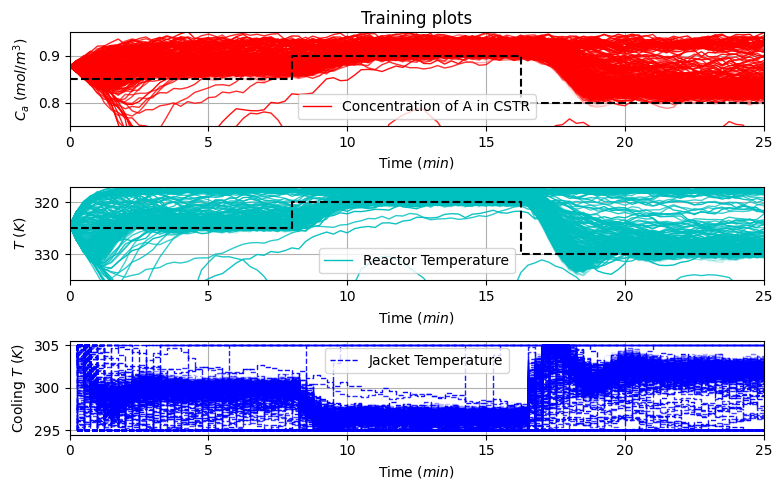

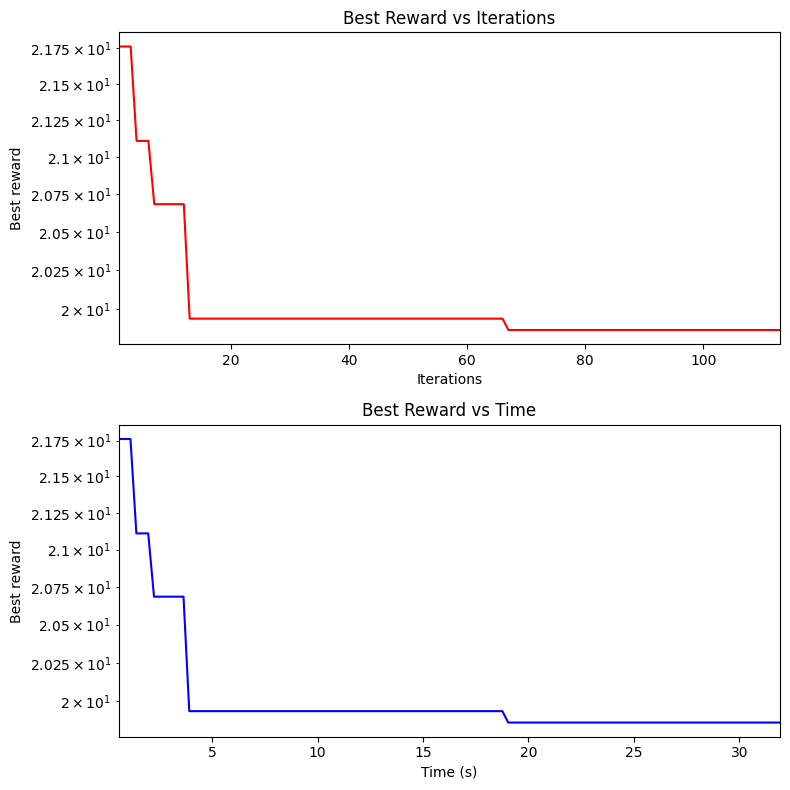

In [11]:
plot_training(data_res, e_tot)
performance_plots(e_tot, time_axis, gbest_history, multiruns=False)

Code for determining average rewards and standard deviations:

In [17]:
# Stability analysis

def reward_stability(algorithm, no_runs, t, time_reps):
    rewards = []
    # times = []
    # gbests = np.zeros((iterations+1, no_runs))
    # time_matrix = np.zeros((iterations+1,))

    # Define the algorithm to be used
    
    def aux_algorithm(algorithm, iterations):
        if algorithm == ArtificialBeeColony:
            best_policy, best_reward, gbest_history, time_axis = ArtificialBeeColony(lower_bound=-5, upper_bound=5, no_employed=50, no_onlooker=round(25), iterations=iterations, distance_value=1, scout_limit=2)
        elif algorithm == ParticleSwarm_PID:
            best_policy, best_reward, gbest_history, time_axis = ParticleSwarm_PID(lower_bound=-5, upper_bound=5, no_particles=round(50), inertia=0.6, cognitive=0.2, social=0.2, tmax=iterations)
        elif algorithm == ParticleSwarm:
            best_policy, best_reward, gbest_history, time_axis = ParticleSwarm(lower_bound=-5, upper_bound=5, no_particles=round(50), inertia=0.6, cognitive=0.2, social=0.2, tmax=iterations)
        elif algorithm == GeneticSearch:
            best_policy, best_reward, gbest_history, time_axis = GeneticSearch(lower_bound=-5, upper_bound=5, mutation_rate=0.3, iterations=iterations, sample_size=50)
        elif algorithm == Firefly:
            best_policy, best_reward, gbest_history, time_axis = Firefly(lower_bound=-5, upper_bound=5, no_fireflies=round(10), iterations=iterations, attractiveness=0.8, absorption=0, randomness=0.2)
        elif algorithm == SimulatedAnnealing:
            best_policy, best_reward, gbest_history, time_axis = SimulatedAnnealing(lower_bound=-5, upper_bound=5, initial_accept_prob=0.4, max_iterations=iterations+1, step_size=0.4, temp_regime='log')
        elif algorithm == DifferentialEvolution:
            best_policy, best_reward, gbest_history, time_axis = DifferentialEvolution(lower_bound=-5, upper_bound=5, iterations=iterations, pop_size=10, cr=0.9, f=0.8)
        elif algorithm == Generalized_policy_search:
            best_policy, best_reward, gbest_history, time_axis = Generalized_policy_search(shrink_ratio=0.9, radius=0.2, evals_shrink=iterations/30, evals=iterations+1, ratio_ls_rs=0.35)
        else:
            print("Invalid algorithm")
        return best_reward, gbest_history, time_axis
        
    # Time the algorithm
    start = time.time()
    best_reward, gbest_history, time_axis = aux_algorithm(algorithm, time_reps)
    stop = time.time()
    iteration_time = (stop - start)/(time_reps)
    no_iterations = round(t/iteration_time)

    rewards = []
    # times = []
    # Run the algorithm multiple times
    for i in range(no_runs):
        print("Run", i)
        best_reward, gbest_history, time_axis = aux_algorithm(algorithm, no_iterations)
        # gbest_time = time_axis[gbest_history.index(best_reward)]
        rewards.append(best_reward)
        # times.append(gbest_time)
        # gbests[:, i] = np.array(gbest_history)

    # Calculate average reward
    avg_reward = np.mean(rewards)
    std_reward = np.std(rewards)
        
    # Plot a histogram of the rewards with the mean and standard deviation
    # plt.hist(rewards, bins = no_bin, edgecolor = 'black')
    # performance_plots(50, time_matrix, gbests, multiruns=True)
    # plt.xlabel('Reward')
    # plt.ylabel('Frequency')
    # plt.title('Stability of the reward')
    # plt.show()
    print("Average reward:", avg_reward)
    print("Standard deviation:", std_reward)
    print("iteration time:", iteration_time)
    print("no_iterations:", no_iterations)
        

    
    return rewards, avg_reward, std_reward, iteration_time, no_iterations

In [18]:
# CSTR Results table

# Initialise data
number_of_runs = 10 # 10 as default
test_time = 30 # seconds, 30 as default
algorithms = [ArtificialBeeColony, ParticleSwarm_PID, ParticleSwarm, GeneticSearch, Firefly, SimulatedAnnealing, DifferentialEvolution, Generalized_policy_search]
results = {}

for algorithm in algorithms:
    print(algorithm)
    if algorithm == Generalized_policy_search or algorithm == SimulatedAnnealing:
        n = 3000
    else:
        n = 100
    _, avg_reward, std_reward, iteration_time, no_iterations = reward_stability(algorithm=algorithm, no_runs=number_of_runs, t=test_time, time_reps=n)
    results[algorithm] = [avg_reward, std_reward, iteration_time, no_iterations]

# Print results
print("Algorithm", " | ","Average reward", " | ", "Standard deviation", " | ", "Iteration time", " | ", "No. iterations")
for algorithm in algorithms:
    print(algorithm, " | ", results[algorithm][0], " | ", results[algorithm][1], " | ", results[algorithm][2], " | ", results[algorithm][3])



<function ArtificialBeeColony at 0x29ff916c0>
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
It

Performance of trained algorithms:

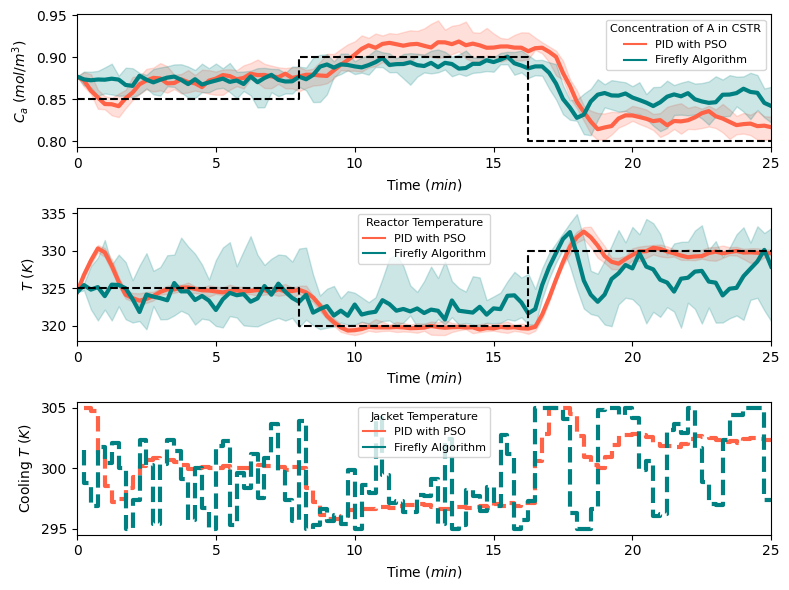

In [14]:
#nx            = 2 # Should be removed from commments if the policy is not PID
#nu            = 1
#hyparams      = {'input_size': nx+2, 'output_size': nu} # include setpoints +
#policy_net_SPS_RL = Net(**hyparams, requires_grad=True, retain_graph=True)
#policy_net_SPS_RL.load_state_dict(best_policy)



reps = 10

Ca_eval = np.zeros((data_res['Ca_dat'].shape[0], reps))
T_eval = np.zeros((data_res['T_dat'].shape[0], reps))
Tc_eval = np.zeros((data_res['Tc_dat'].shape[0], reps))

for r_i in range(reps):
  Ca_eval[:,r_i], T_eval[:,r_i], Tc_eval[:,r_i] = J_PolicyCSTR(best_policy,
                                                               policy_alg='PID', 
                                                                collect_training_data=False, 
                                                                traj=True)
  

nx            = 2
nu            = 1
hyparams      = {'input_size': nx+2, 'output_size': nu} # include setpoints +
policy_net_SPS_RL = Net(**hyparams, requires_grad=True, retain_graph=True)
policy_net_SPS_RL.load_state_dict(best_policy2)

Ca_eval2 = np.zeros((data_res['Ca_dat'].shape[0], reps))
T_eval2 = np.zeros((data_res['T_dat'].shape[0], reps))
Tc_eval2 = np.zeros((data_res['Tc_dat'].shape[0], reps))
  
for r_i in range(reps):
  Ca_eval2[:,r_i], T_eval2[:,r_i], Tc_eval2[:,r_i] = J_PolicyCSTR(policy_net_SPS_RL,
                                                               policy_alg='SPS_RL', 
                                                                collect_training_data=False, 
                                                                traj=True)

# Plot the results
plot_simulation(Ca_eval, T_eval, Tc_eval, Ca_eval2, T_eval2, Tc_eval2, data_res)